# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Data Exploration

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


The transcript dataset is one we definitely are going to need to clean up a little bit. I will start by extracting the offer id, amount and rewards fields from the value field into its own columns for use later.

In [6]:
# Clean transcript dataset to extract the offer ids and amounts from the value field

# Functions to update offer id and amount
def update_offerid(value): 
    if 'offer id' in value:
        item = value.get('offer id')
    else:
        item = value.get('offer_id')
    return item

def update_amount(value):
    item = value.get('amount')
    return item

def update_userreward(value):
    item = value.get('reward')
    return item

transcript_clean = transcript.copy()
transcript_clean['offer_id'] = transcript_clean['value'].apply(update_offerid)
transcript_clean['amount'] = transcript_clean['value'].apply(update_amount)
transcript_clean['user_reward'] = transcript_clean['value'].apply(update_userreward)

In [7]:
transcript_clean.head()

,event,person,time,value,offer_id,amount,user_reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [8]:
# Check for nulls in transcript dataset
for c in transcript.columns.values:
    print(c,': ', transcript[c].isnull().sum())

event :  0
person :  0
time :  0
value :  0


CHANNEL ANALYSIS AND THEIR INFLUENCE ON OFFER COMPLETION RATES

For this analysis, we will be looking at all offers completed from the transcript dataset and matching them against the portfolio datasets to see which channels those offers came from.

In [9]:
# Check for nulls in portfolio dataset
for c in portfolio.columns.values:
    print(c,': ', portfolio[c].isnull().sum())

channels :  0
difficulty :  0
duration :  0
id :  0
offer_type :  0
reward :  0


In [10]:
# Get all offer ids for completed offers from transcript

pd.options.mode.chained_assignment = None

completed_offers = transcript_clean[transcript_clean['event'] == 'offer completed']
channels_df = portfolio[portfolio['id'].isin(completed_offers['offer_id'])]

def update_channel(c):
    channels_df[c] = channels_df['channels'].apply(lambda x: 1 if c in x else 0)

channel_list = ['email','social','mobile','web']
for c in channel_list:
    update_channel(c)

channels_df

,channels,difficulty,duration,id,offer_type,reward,email,social,mobile,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,0,1,1


In [11]:
channels_df.groupby(['offer_type']).agg({'email':'sum','mobile':'sum','social':'sum','web':'sum'})

,email,mobile,social,web
offer_type,,,,
bogo,4,4,3,3
discount,4,3,2,4


ANALYSIS RESULTS

There are only 8 completed offers so there isn't much data here, but from what we see, every offer has been sent via email, which is the most common channel overall. Social is the least common channel. Similar results are observed when looking at the data broken down by offer type as well.

This analysis would be more effective with a larger dataset, so not drawing any conclusions here.

ANALYSIS OF OFFER TYPES TO UNDERSTAND IMPACT ON VIEWING AND COMPLETION OF OFFERS

We will be looking at how receiving, viewing and completion of offers differs by offer types - bogo, discount and informational.

For this analysis, we will start by creating a dataframe out of the transcript dataset that contains records for each person and offer id, if they received, viewed and/or completed the offer. We will be removing any records pertaining to purchases since those are not relevant for this particular analysis. 

In [12]:
# Create offer dataframe as a subset of transcript 
user_offers = transcript_clean[['event','person','offer_id']]

# Remove all purchase transactions
user_offers = user_offers[user_offers['event'] != 'transaction']
user_offers.head()

,event,person,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0


In [13]:
user_offers_clean_columns = ['person', 'offer_id', 'offer_recd', 'offer_viewed', 'offer_comp']
user_offer_list = []

unique_person_offer = user_offers.groupby(['person','offer_id']).size().reset_index().rename(columns={0:'count'})

for index, row in unique_person_offer.iterrows():
    viewed_flag = 0
    recd_flag = 0
    comp_flag = 0
    filtered_rows = user_offers[(user_offers['person'].isin([row['person']])) & (user_offers['offer_id'].isin([row['offer_id']]))]
    for e in filtered_rows['event']:
        if 'offer received' in e:
            recd_flag = 1
        elif 'offer viewed' in e:
            viewed_flag = 1
        else: 
            comp_flag = 1

    user_offer_list.append([row['person'], row['offer_id'], recd_flag, viewed_flag, comp_flag])

user_offers_clean = pd.DataFrame(user_offer_list, columns=user_offers_clean_columns)
user_offers_clean.head()

,person,offer_id,offer_recd,offer_viewed,offer_comp
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1


In [14]:
def update_offerdetails(offerid):
    df = portfolio[portfolio['id'] == offerid]
    return df['offer_type'].values[0], df['difficulty'].values[0], df['duration'].values[0], df['reward'].values[0], df['channels'].values[0]

user_offers_clean[['offer_type','difficulty','duration','offer_reward','channels']] = user_offers_clean['offer_id'].apply(lambda x: pd.Series([update_offerdetails(x)[0],update_offerdetails(x)[1],update_offerdetails(x)[2],update_offerdetails(x)[3],update_offerdetails(x)[4]]))

user_offers_clean.head()

,person,offer_id,offer_recd,offer_viewed,offer_comp,offer_type,difficulty,duration,offer_reward,channels
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,discount,10,7,2,"[web, email, mobile]"
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,0,informational,0,4,0,"[web, email, mobile]"
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,0,informational,0,3,0,"[email, mobile, social]"
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,bogo,5,5,5,"[web, email, mobile, social]"
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,discount,10,10,2,"[web, email, mobile, social]"


In [15]:
# Explore offer counts by offer type
user_offers_clean.groupby('offer_type')['offer_id'].nunique()

offer_type
bogo             4
discount         4
informational    2
Name: offer_id, dtype: int64

In [16]:
offer_type_df = user_offers_clean.groupby(['offer_type'])['offer_recd','offer_viewed','offer_comp'].sum().reset_index()
offer_type_df.head()

,offer_type,offer_recd,offer_viewed,offer_comp
0,bogo,25321,21546,13587
1,discount,25316,18280,15409
2,informational,12651,9309,0


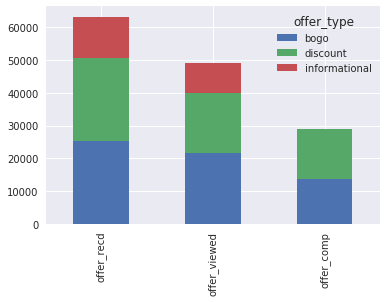

In [17]:
sns.set()
offer_type_df.set_index('offer_type').T.plot(kind='bar', stacked=True);

ANALYSIS RESULTS

Based on the above, we can see that even though almost the same amount of bogo and discount offers are received, bogo offers are viewed much more than discount offers. Bogo offers have an 85% viewing rate vs. discount offers which have a 72% viewing rate. 

It is also interesting to note that even though the viewing rates are better with bogo, the completion rates are much better for discount offers. For bogos, 53.6% of offers received were completed, whereas for discounts, 61% of offers received were completed.

Informational offers have a 73.5% viewing rate. 

Based on this analysis, you could consider the following approches:

- Consider making bogos more attractive such as personalizing based on consumer previous purchase behavior for example, since the viewing rates are definitely high for these offer types
- Consider making the discount offers more visually appealing to increase viewing rates 

ANALYSIS OF USER GROUPS TO UNDERSTAND IMPACT ON VIEWING AND COMPLETION OF OFFERS

Next, we will be analyzing the demographics (age, gender, income) of 4 different groups:

1. Users that receive offers, view offers and complete offers 
2. Users that receive offers, view offers and DO NOT complete offers
3. Users that receive offers and DO NOT view offers and DO NOT complete offers
4. Users that receive offers and DO NOT view offers and complete offers

We will be using the user_offers_clean dataframe built previously. We will start out by looking at the profile dataset further to check if it requires any cleansing. 

Since completion is an important consideration for our analysis, we will be removing 'information' offers from this analysis, since 'informational' offers can only be received and viewed, but not completed. 


In [18]:
# Check for nulls in portfolio dataset
for c in profile.columns.values:
    print(c,': ', profile[c].isnull().sum())

age :  0
became_member_on :  0
gender :  2175
id :  0
income :  2175


In [19]:
profile[profile['age'] == 118].shape[0]

2175

Based on the above results, it looks like the profile dataset could use some cleaning up. There are 2175 records that have both the gender and income fields as null and from the initial preview of this dataset, it seems like these records with null values all have age 118 associated with them. Since a lot of our analysis will be based on demographics, and these records have no significant demographic attributes associated with them, I have decided to drop these records, so as to not skew my analysis.

In [20]:
# Drop profile records that have age 118, thereby dropping all records with gender and income as Nans
profile_clean = profile[profile['age'] < 118]
profile_clean.shape

(14825, 5)

In [21]:
# Drop person id records from transcript that are not in profile
demo_df = user_offers_clean.copy()
demo_df = demo_df[demo_df['person'].isin(profile_clean['id'])]
demo_df.head()

,person,offer_id,offer_recd,offer_viewed,offer_comp,offer_type,difficulty,duration,offer_reward,channels
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,discount,10,7,2,"[web, email, mobile]"
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,0,informational,0,4,0,"[web, email, mobile]"
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,0,informational,0,3,0,"[email, mobile, social]"
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,bogo,5,5,5,"[web, email, mobile, social]"
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,discount,10,10,2,"[web, email, mobile, social]"


In [22]:
# Remove informational offer types
demo_df = demo_df[demo_df['offer_type']!= 'informational']
demo_df.head()

,person,offer_id,offer_recd,offer_viewed,offer_comp,offer_type,difficulty,duration,offer_reward,channels
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,discount,10,7,2,"[web, email, mobile]"
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,bogo,5,5,5,"[web, email, mobile, social]"
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,discount,10,10,2,"[web, email, mobile, social]"
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,discount,20,10,5,"[web, email]"
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,discount,7,7,3,"[web, email, mobile, social]"


In [23]:
def get_profiles(df, recd, viewed, comp):

    filtered_df = df[(df['offer_recd'] == recd) & 
                          (df['offer_viewed'] == viewed) & (df['offer_comp'] == comp)]

    # Get unique person ids
    unique_person_ids = filtered_df['person'].unique()

    unique_profiles = profile_clean[profile_clean['id'].isin(unique_person_ids)]
    
    return unique_profiles

def show_plots(unique_profiles):
    f1 = plt.figure(figsize=(64,8))
    axis1 = f1.add_subplot(234)
    axis1.title.set_text('Age Distribution')
    sns.countplot(unique_profiles['age'])
    plt.axvline(unique_profiles['age'].mean(), color='k', linestyle='dashed', linewidth=1)

    f2 = plt.figure(figsize=(64,8))
    axis2 = f2.add_subplot(234)
    axis2.title.set_text('Gender Distribution')
    sns.countplot(unique_profiles['gender'])

    f3 = plt.figure(figsize=(64,8))
    axis3 = f3.add_subplot(234)
    axis3.title.set_text('Income Distribution')
    sns.countplot(unique_profiles['income'])
    axis3.set_xticklabels(axis3.get_xticklabels(), rotation=40, ha="right", fontsize=7)

    plt.show()

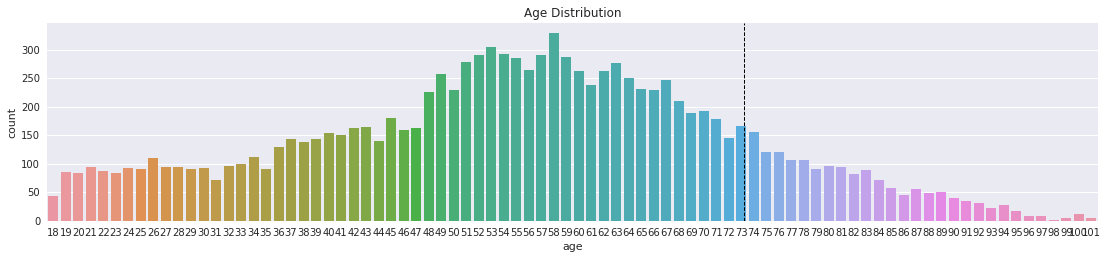

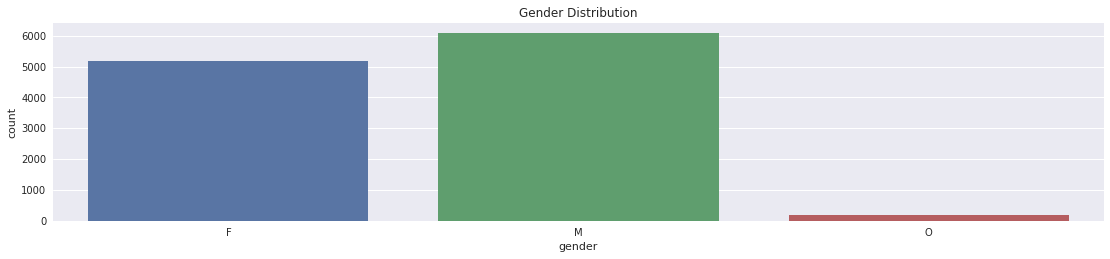

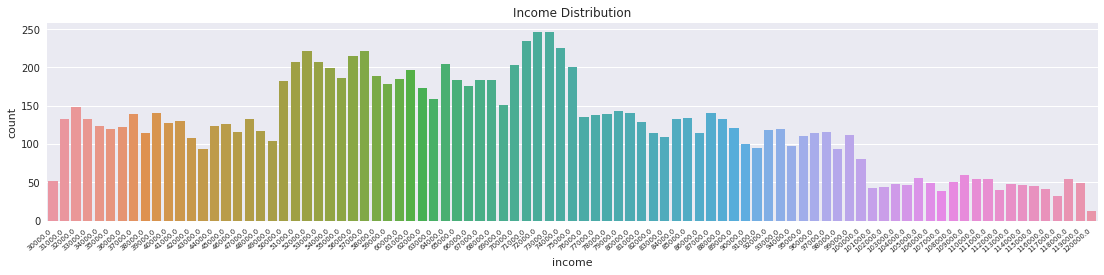

In [24]:
# Analyze Group 1 - Users that receive offers, view offers and complete offers 
unique_profiles_group1 = get_profiles(demo_df, 1, 1, 1)
show_plots(unique_profiles_group1)

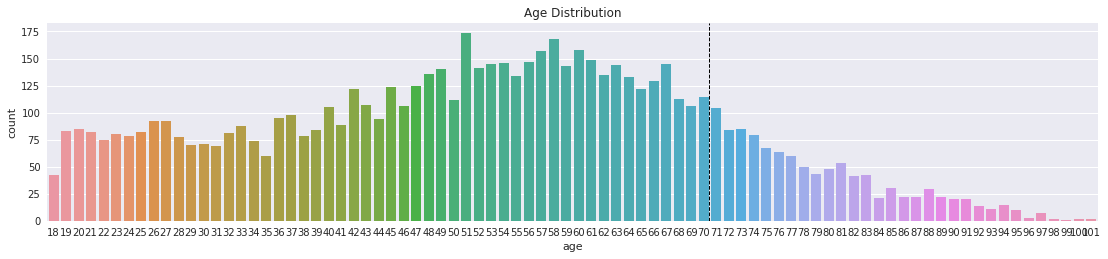

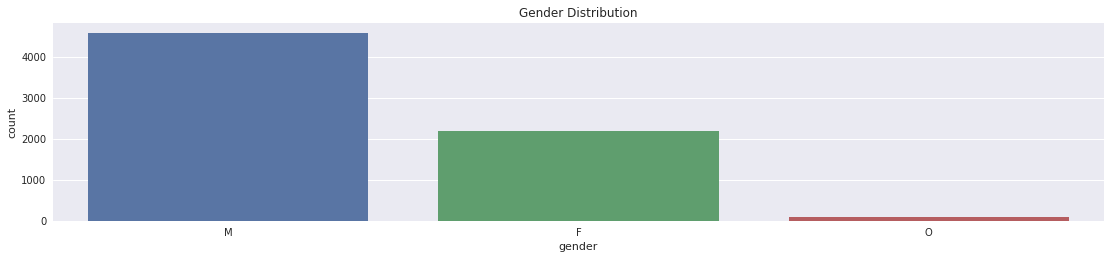

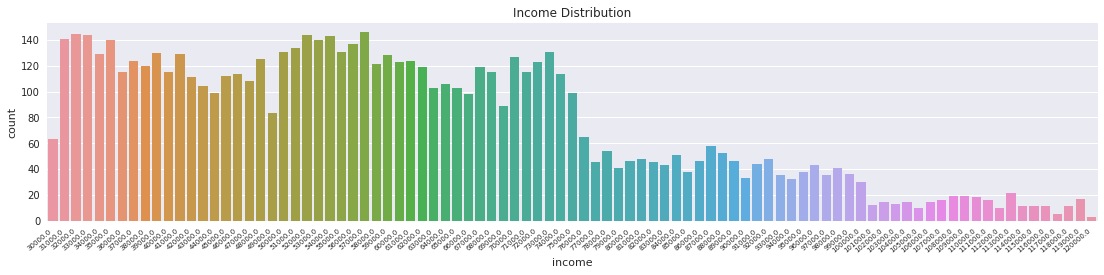

In [25]:
# Analyze Group 2 - Users that receive offers, view offers and DO NOT complete offers
unique_profiles_group2 = get_profiles(demo_df, 1, 1, 0)
show_plots(unique_profiles_group2)

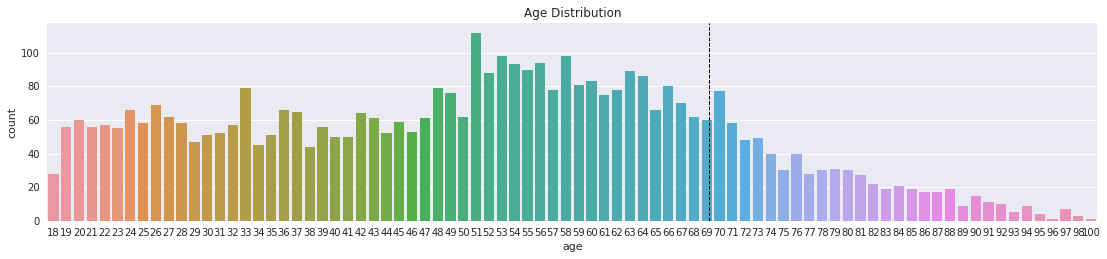

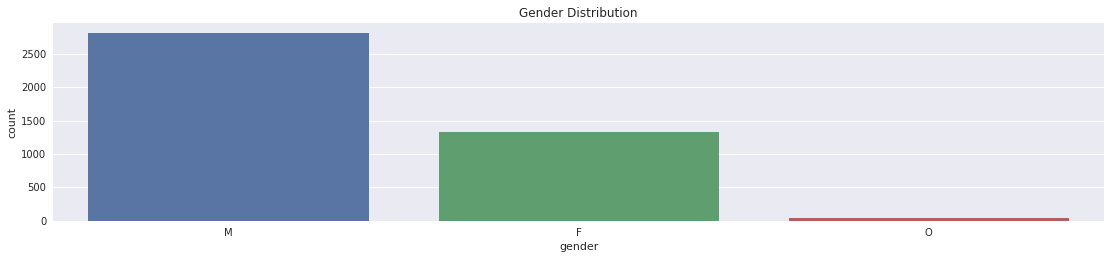

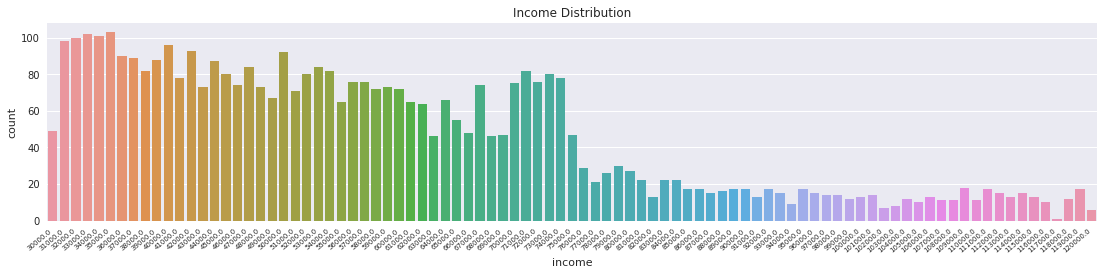

In [26]:
# Analyze Group 3 - Users that receive offers and DO NOT view offers and DO NOT complete offers
unique_profiles_group3 = get_profiles(demo_df, 1, 0, 0)
show_plots(unique_profiles_group3)


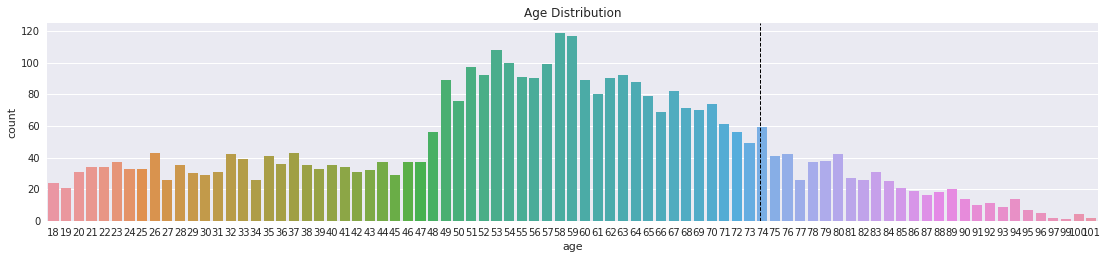

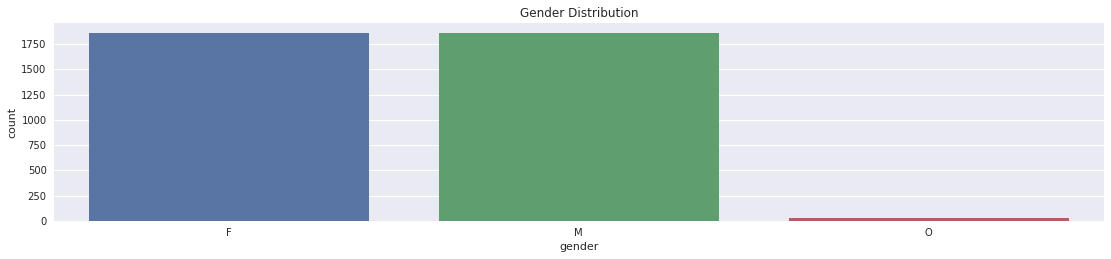

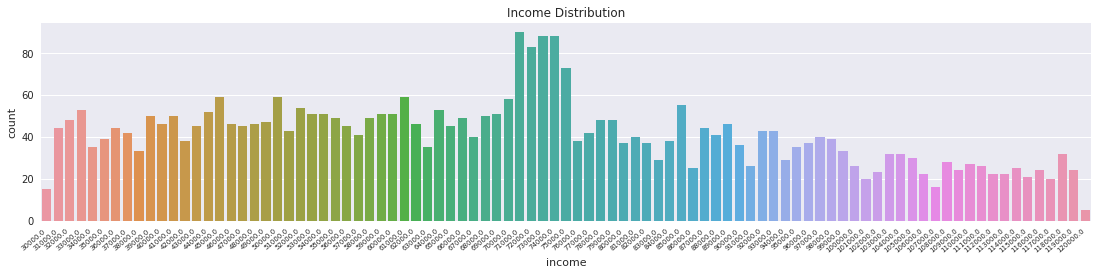

In [27]:
# Analyze Group 4 - Users that receive offers and DO NOT view offers and complete offers
unique_profiles_group4 = get_profiles(demo_df, 1, 0, 1)
show_plots(unique_profiles_group4)

In [28]:
# Print group summaries
def print_summary(unique_profiles, i):
    print('Group ',i, ' size: ', unique_profiles.shape[0])
    print('Group ', i, ' - Top Ages: \n', unique_profiles['age'].value_counts().head(3))
    print('Group ', i, ' - Average Age: \n', unique_profiles['age'].mean())
    print('Group ', i, ' - Top Gender: \n', unique_profiles['gender'].value_counts().head(1))
    print('Group ', i, ' - Top Income: \n', unique_profiles['income'].value_counts().head(3))
    print('Group ', i, ' - Average Income: \n', unique_profiles['income'].mean())
    
    
print_summary(unique_profiles_group1, 1)
print_summary(unique_profiles_group2, 2)
print_summary(unique_profiles_group3, 3)
print_summary(unique_profiles_group4, 4)

Group  1  size:  11452
Group  1  - Top Ages: 
 58    330
53    304
54    292
Name: age, dtype: int64
Group  1  - Average Age: 
 55.2326231226
Group  1  - Top Gender: 
 M    6105
Name: gender, dtype: int64
Group  1  - Top Income: 
 72000.0    246
73000.0    246
71000.0    235
Name: income, dtype: int64
Group  1  - Average Income: 
 67964.7223192
Group  2  size:  6872
Group  2  - Top Ages: 
 51    174
58    168
60    158
Name: age, dtype: int64
Group  2  - Average Age: 
 52.3787834692
Group  2  - Top Gender: 
 M    4600
Name: gender, dtype: int64
Group  2  - Top Income: 
 57000.0    146
32000.0    145
52000.0    144
Name: income, dtype: int64
Group  2  - Average Income: 
 59991.8509895
Group  3  size:  4183
Group  3  - Top Ages: 
 51    112
53     98
58     98
Name: age, dtype: int64
Group  3  - Average Age: 
 51.1773846522
Group  3  - Top Gender: 
 M    2817
Name: gender, dtype: int64
Group  3  - Top Income: 
 35000.0    103
33000.0    102
34000.0    101
Name: income, dtype: int64
Group

ANALYSIS RESULTS

The insights for Group 4 are the most interesting. Group 4 are the people that receive offers, do not view the offers, and yet end up completing the offers. This means that the offer has no influence on them, they are people who would make purchases regardless. These consumers may be considered as loyal customers. 

Demographic highlights: Group 4 consumers have almost an equal concentration of females as males, although, females lead by a small margin, which is unlike any other groups. Group 4 also has the highest average income of all groups at almost 70,000. 

It may also be helpful to consider a few approaches for this group of customers:

1. Consider changing the offers so they are more lucrative for these types of consumers considering they are more loyal to the brand than others, to see if their offer consumption behavior changes
2. Consider not sending offers to these consumers to save on cost, but monitor to ensure these consumers stay loyal. Explore other engagement channels and methods with these consumers. 

Some other noticeable observations from the results are summarized below:

- Group 3 is the only group that has a higher concentration of income along the lower end of the income scale. 
- Apart from Group 4, Group 1 has a better female to male consumer ratio than Groups 2 and 3 where males dominate for the most part. 
- Looking at group sizes, we see that Group 1 size > Group 2 size > Group 3 size > Group 4 size. It is definitely good news that Group 1 is the largest, where consumers receive, view and complete offers.

CLUSTER ANALYSIS - WHICH USERS REACT BEST TO WHICH OFFER TYPES


In [29]:
cluster_df = profile_clean.copy()
cluster_df.head() 

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [30]:
user_offers_clean.head()

,person,offer_id,offer_recd,offer_viewed,offer_comp,offer_type,difficulty,duration,offer_reward,channels
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,discount,10,7,2,"[web, email, mobile]"
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,0,informational,0,4,0,"[web, email, mobile]"
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,0,informational,0,3,0,"[email, mobile, social]"
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,bogo,5,5,5,"[web, email, mobile, social]"
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,discount,10,10,2,"[web, email, mobile, social]"


In [31]:
total_offer_recd = []
total_offer_viewed = []
total_offer_comp = []
avg_offer_reward = []
avg_difficulty = []
avg_duration = []
for p in cluster_df['id']:
    person_df = user_offers_clean[user_offers_clean['person'] == p]
    total_offer_recd.append(person_df['offer_recd'].sum())
    total_offer_viewed.append(person_df['offer_viewed'].sum())
    total_offer_comp.append(person_df['offer_comp'].sum())
    avg_offer_reward.append(person_df['offer_reward'].mean())
    avg_difficulty.append(person_df['difficulty'].mean())
    avg_duration.append(person_df['duration'].mean())

cluster_df['total_offer_recd'] = total_offer_recd
cluster_df['total_offer_viewed'] = total_offer_viewed
cluster_df['total_offer_comp'] = total_offer_comp
cluster_df['avg_offer_reward'] = avg_offer_reward
cluster_df['avg_difficulty'] = avg_difficulty
cluster_df['avg_duration'] = avg_duration
cluster_df.head()

,age,became_member_on,gender,id,income,total_offer_recd,total_offer_viewed,total_offer_comp,avg_offer_reward,avg_difficulty,avg_duration
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2,0,1,2.500000,2.500000,5.50
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4,4,3,5.000000,5.000000,5.50
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,4,3,2,2.250000,6.250000,7.00
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,4,4,4,3.500000,7.500000,7.25
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,3,2,1,1.666667,5.666667,7.00


In [32]:
purchase_df = transcript_clean[transcript_clean['event'] == 'transaction']
purchase_df.head()

,event,person,time,value,offer_id,amount,user_reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},None,0.83,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},None,34.56,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},None,13.23,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},None,19.51,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},None,18.97,NaN


In [33]:
total_trans = []
total_amount = []
avg_amount = []
min_amount = []
max_amount = []
for p in cluster_df['id']:
    person_df = purchase_df[purchase_df['person'] == p]
    total_trans.append(person_df['event'].count())
    total_amount.append(person_df['amount'].sum())
    avg_amount.append(person_df['amount'].mean())
    min_amount.append(person_df['amount'].min())
    max_amount.append(person_df['amount'].max())

cluster_df['total_trans'] = total_trans
cluster_df['total_amount'] = total_amount
cluster_df['avg_amount'] = avg_amount
cluster_df['min_amount'] = min_amount
cluster_df['max_amount'] = max_amount
cluster_df.head()

,age,became_member_on,gender,id,income,total_offer_recd,total_offer_viewed,total_offer_comp,avg_offer_reward,avg_difficulty,avg_duration,total_trans,total_amount,avg_amount,min_amount,max_amount
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2,0,1,2.500000,2.500000,5.50,3,77.01,25.670000,21.51,32.28
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4,4,3,5.000000,5.000000,5.50,7,159.27,22.752857,17.78,29.72
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,4,3,2,2.250000,6.250000,7.00,3,57.73,19.243333,17.88,21.43
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,4,4,4,3.500000,7.500000,7.25,3,36.43,12.143333,9.54,15.63
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,3,2,1,1.666667,5.666667,7.00,4,15.62,3.905000,0.87,7.14


In [34]:
user_reward_df = transcript_clean[transcript_clean['event'] == 'offer completed']
user_reward_df.head()

,event,person,time,value,offer_id,amount,user_reward
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,NaN,2.0
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10.0
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0


In [35]:
total_user_reward = []
for p in cluster_df['id']:
    person_df = user_reward_df[user_reward_df['person'] == p]
    total_user_reward.append(person_df['user_reward'].sum())
cluster_df['total_user_reward'] = total_user_reward

In [36]:
cluster_df.head()

,age,became_member_on,gender,id,income,total_offer_recd,total_offer_viewed,total_offer_comp,avg_offer_reward,avg_difficulty,avg_duration,total_trans,total_amount,avg_amount,min_amount,max_amount,total_user_reward
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2,0,1,2.500000,2.500000,5.50,3,77.01,25.670000,21.51,32.28,5.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4,4,3,5.000000,5.000000,5.50,7,159.27,22.752857,17.78,29.72,20.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,4,3,2,2.250000,6.250000,7.00,3,57.73,19.243333,17.88,21.43,7.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,4,4,4,3.500000,7.500000,7.25,3,36.43,12.143333,9.54,15.63,19.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,3,2,1,1.666667,5.666667,7.00,4,15.62,3.905000,0.87,7.14,2.0


In [37]:
total_email = []
total_web = []
total_mobile = []
total_social = []
for p in cluster_df['id']:
    person_df = user_offers_clean[user_offers_clean['person'] == p]
    email = 0
    web = 0
    mobile = 0
    social = 0
    for c in person_df['channels']:
        if 'email' in c:
            email += 1
        if 'mobile' in c:
            mobile += 1
        if 'social' in c:
            social += 1
        if 'web' in c:
            web += 1
    total_email.append(email)
    total_mobile.append(mobile)
    total_social.append(social)
    total_web.append(web)

cluster_df['total_email'] = total_email
cluster_df['total_mobile'] = total_mobile
cluster_df['total_social'] = total_social
cluster_df['total_web'] = total_web
cluster_df.head()

,age,became_member_on,gender,id,income,total_offer_recd,total_offer_viewed,total_offer_comp,avg_offer_reward,avg_difficulty,...,total_trans,total_amount,avg_amount,min_amount,max_amount,total_user_reward,total_email,total_mobile,total_social,total_web
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2,0,1,2.500000,2.500000,...,3,77.01,25.670000,21.51,32.28,5.0,2,2,0,2
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4,4,3,5.000000,5.000000,...,7,159.27,22.752857,17.78,29.72,20.0,4,4,3,2
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,4,3,2,2.250000,6.250000,...,3,57.73,19.243333,17.88,21.43,7.0,4,4,1,4
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,4,4,4,3.500000,7.500000,...,3,36.43,12.143333,9.54,15.63,19.0,4,4,2,4
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,3,2,1,1.666667,5.666667,...,4,15.62,3.905000,0.87,7.14,2.0,3,3,2,3


In [38]:
total_bogo = []
total_info = []
total_discount = []

for p in cluster_df['id']:
    person_df = user_offers_clean[user_offers_clean['person'] == p]
    offer_type_lst = list(person_df['offer_type'].values)
    total_bogo.append(offer_type_lst.count('bogo'))
    total_info.append(offer_type_lst.count('informational'))
    total_discount.append(offer_type_lst.count('discount'))


cluster_df['total_bogo'] = total_bogo
cluster_df['total_info'] = total_info
cluster_df['total_discount'] = total_discount

cluster_df.head()

,age,became_member_on,gender,id,income,total_offer_recd,total_offer_viewed,total_offer_comp,avg_offer_reward,avg_difficulty,...,min_amount,max_amount,total_user_reward,total_email,total_mobile,total_social,total_web,total_bogo,total_info,total_discount
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2,0,1,2.500000,2.500000,...,21.51,32.28,5.0,2,2,0,2,1,1,0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4,4,3,5.000000,5.000000,...,17.78,29.72,20.0,4,4,3,2,3,1,0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,4,3,2,2.250000,6.250000,...,17.88,21.43,7.0,4,4,1,4,1,1,2
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,4,4,4,3.500000,7.500000,...,9.54,15.63,19.0,4,4,2,4,2,0,2
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,3,2,1,1.666667,5.666667,...,0.87,7.14,2.0,3,3,2,3,0,1,2


In [54]:
# Check for nulls in cluster_df dataset
# Check for nulls in portfolio dataset
for c in cluster_df.columns.values:
    print(c,': ', cluster_df[c].isnull().sum())

age :  0
became_member_on :  0
gender :  0
id :  0
income :  0
total_offer_recd :  0
total_offer_viewed :  0
total_offer_comp :  0
avg_offer_reward :  0
avg_difficulty :  0
avg_duration :  0
total_trans :  0
total_amount :  0
avg_amount :  0
min_amount :  0
max_amount :  0
total_user_reward :  0
total_email :  0
total_mobile :  0
total_social :  0
total_web :  0
total_bogo :  0
total_info :  0
total_discount :  0


Based on the above, it looks like there are 5 records that have avg_offer_reward, avg_difficulty and avg_duration as null. These are all fields associated with offers so let's explore these fields further.

In [45]:
cluster_df[cluster_df['avg_duration'].isnull()]

,age,became_member_on,gender,id,income,total_offer_recd,total_offer_viewed,total_offer_comp,avg_offer_reward,avg_difficulty,...,min_amount,max_amount,total_user_reward,total_email,total_mobile,total_social,total_web,total_bogo,total_info,total_discount
872,72,20171014,F,c6e579c6821c41d1a7a6a9cf936e91bb,35000.0,0,0,0,0.0,NaN,...,0.65,3.14,0.0,0,0,0,0,0,0,0
5639,66,20170929,F,eb540099db834cf59001f83a4561aef3,34000.0,0,0,0,0.0,NaN,...,4.74,8.78,0.0,0,0,0,0,0,0,0
6789,55,20160816,F,3a4874d8f0ef42b9a1b72294902afea9,88000.0,0,0,0,0.0,NaN,...,17.67,27.20,0.0,0,0,0,0,0,0,0
14763,54,20170106,F,ae8111e7e8cd4b60a8d35c42c1110555,72000.0,0,0,0,0.0,NaN,...,9.72,28.70,0.0,0,0,0,0,0,0,0
15391,91,20151005,M,12ede229379747bd8d74ccdc20097ca3,70000.0,0,0,0,0.0,NaN,...,16.62,27.60,0.0,0,0,0,0,0,0,0


We can see that these users have never received any offers, but are in the dataset because they have made purchases. We will keep these records in our dataset, and simply set the avg_offer_reward, avg_difficulty and avg_duration to 0.

In [46]:
cluster_df['avg_offer_reward'] = cluster_df['avg_offer_reward'].fillna(0)
cluster_df['avg_difficulty'] = cluster_df['avg_difficulty'].fillna(0)
cluster_df['avg_duration'] = cluster_df['avg_duration'].fillna(0)

Next, let's look at avg_amount, min_amount and max_amount fields which have 333 values as Nans. Perhaps these are all users that have made no purchases.

In [52]:
cluster_df[cluster_df['avg_amount'].isnull()]['total_trans'].sum()

0

As suspected, these users have no transaction amounts since they have not made any purchases. We will set these Nan values to 0 as well.

In [53]:
cluster_df['avg_amount'] = cluster_df['avg_amount'].fillna(0)
cluster_df['min_amount'] = cluster_df['min_amount'].fillna(0)
cluster_df['max_amount'] = cluster_df['max_amount'].fillna(0)

In [59]:
cluster_df.head()

,age,became_member_on,gender,id,income,total_offer_recd,total_offer_viewed,total_offer_comp,avg_offer_reward,avg_difficulty,avg_duration,total_trans,total_amount,avg_amount,min_amount,max_amount,total_user_reward,total_email,total_mobile,total_social,total_web,total_bogo,total_info,total_discount
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2,0,1,2.500000,2.500000,5.50,3,77.01,25.670000,21.51,32.28,5.0,2,2,0,2,1,1,0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4,4,3,5.000000,5.000000,5.50,7,159.27,22.752857,17.78,29.72,20.0,4,4,3,2,3,1,0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,4,3,2,2.250000,6.250000,7.00,3,57.73,19.243333,17.88,21.43,7.0,4,4,1,4,1,1,2
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,4,4,4,3.500000,7.500000,7.25,3,36.43,12.143333,9.54,15.63,19.0,4,4,2,4,2,0,2
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,3,2,1,1.666667,5.666667,7.00,4,15.62,3.905000,0.87,7.14,2.0,3,3,2,3,0,1,2


Next, let's clean up the following fields:

- became_member_on: In order have a good numeric feature for our clustering, I will be cleaning up this field so it can be number of days a user has been a member instead of a date field
- gender: I will be dummy encoding this field since it's categorical


In [74]:
import datetime
from datetime import date
todays_date = datetime.datetime.today().strftime('%Y-%m-%d')
todays_yy, todays_mm, todays_dd = todays_date.split('-')

num_days = []
for d in cluster_df['became_member_on']:
    rec_date = str(d)
    rec_yy = int(rec_date[0:4])
    rec_mm = int(rec_date[4:6])
    rec_dd = int(rec_date[6:8])
    d0 = date(rec_yy, rec_mm, rec_dd)
    d1 = date(int(todays_yy), int(todays_mm), int(todays_dd))
    delta = d1 - d0
    num_days.append(delta.days)
    
cluster_df['num_days'] = num_days
# Drop became_member_on field
cluster_df = cluster_df.drop('became_member_on', axis=1)

In [75]:
cluster_df.head()

,age,gender,id,income,total_offer_recd,total_offer_viewed,total_offer_comp,avg_offer_reward,avg_difficulty,avg_duration,total_trans,total_amount,avg_amount,min_amount,max_amount,total_user_reward,total_email,total_mobile,total_social,total_web,total_bogo,total_info,total_discount,num_days
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2,0,1,2.500000,2.500000,5.50,3,77.01,25.670000,21.51,32.28,5.0,2,2,0,2,1,1,0,623
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4,4,3,5.000000,5.000000,5.50,7,159.27,22.752857,17.78,29.72,20.0,4,4,3,2,3,1,0,690
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,4,3,2,2.250000,6.250000,7.00,3,57.73,19.243333,17.88,21.43,7.0,4,4,1,4,1,1,2,338
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,4,4,4,3.500000,7.500000,7.25,3,36.43,12.143333,9.54,15.63,19.0,4,4,2,4,2,0,2,414
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,3,2,1,1.666667,5.666667,7.00,4,15.62,3.905000,0.87,7.14,2.0,3,3,2,3,0,1,2,504


In [77]:
cluster_df = pd.get_dummies(cluster_df, columns=['gender'])

In [154]:
cluster_df = cluster_df.drop('id', axis=1)
cluster_df.head()

KeyError: "['id'] not found in axis"

In [155]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#scaler = StandardScaler()
#cluster_df_scaler = scaler.fit_transform(cluster_df)

In [95]:
pca = PCA()
cluster_df_pca = pca.fit_transform(cluster_df_scaler)

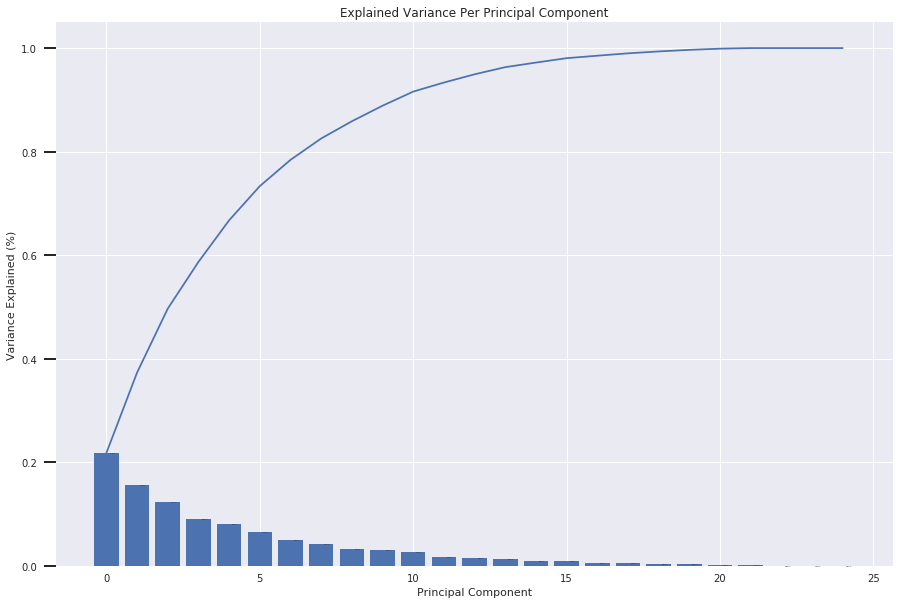

In [96]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=2)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)

In [98]:
# Investigate variance for every 10 features for first 20 features
prev_variance = 0
for i in range(0,20,1):
    current_variance = pca.explained_variance_ratio_[:i].sum()
    delta_variance = current_variance - prev_variance
    print(i, current_variance, delta_variance)
    prev_variance = current_variance

0 0.0 0.0
1 0.218054430998 0.218054430998
2 0.373195599208 0.15514116821
3 0.496731335293 0.123535736085
4 0.586970768082 0.0902394327892
5 0.667347945763 0.0803771776804
6 0.733368350285 0.0660204045222
7 0.78406634493 0.0506979946456
8 0.825363510605 0.0412971656748
9 0.858640860363 0.0332773497581
10 0.888669594455 0.0300287340918
11 0.915949692605 0.0272800981502
12 0.933417646098 0.0174679534922
13 0.949387688661 0.0159700425639
14 0.96316623421 0.0137785455482
15 0.972014354011 0.00884811980175
16 0.98050963176 0.00849527774848
17 0.985286184073 0.00477655231321
18 0.989868328389 0.00458214431599
19 0.99353074488 0.00366241649073


In [100]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(11)
cluster_df_pca = pca.fit_transform(cluster_df_scaler)

In [156]:
centers = []
scores = []
for k in range(1,20):  
    kmeans = KMeans(k)
    model = kmeans.fit(cluster_df)
    score = abs(model.score(cluster_df))
    centers.append(k)
    scores.append(score)
print(centers)
print(scores)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[6918171421634.9629, 2204399351422.0273, 996396925483.05688, 573790119857.07788, 358960828681.43042, 252080421713.26505, 185677130167.88715, 139826256120.25653, 116171539291.13298, 94935492604.242126, 79679073373.441376, 65759835527.109283, 56776071282.388382, 50324406509.95372, 43503401811.131882, 38277071810.164368, 35168853680.526001, 30893143223.440346, 28256902136.875153]


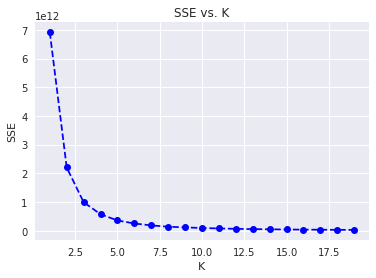

In [157]:
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [158]:
kmeans = KMeans(3)
model = kmeans.fit(cluster_df)
predictions = model.predict(cluster_df)
#centroids = model.cluster_centers_
#centroids

In [159]:
cluster_df['cluster_num'] = predictions
cluster_df.cluster_num.value_counts()

1    6142
0    5391
2    3292
Name: cluster_num, dtype: int64

In [135]:
print(cluster_df[cluster_df['cluster_num'] == 0].total_offer_comp.mean())
print(cluster_df[cluster_df['cluster_num'] == 1].total_offer_comp.mean())
print(cluster_df[cluster_df['cluster_num'] == 2].total_offer_comp.mean())
print(cluster_df[cluster_df['cluster_num'] == 3].total_offer_comp.mean())
print(cluster_df[cluster_df['cluster_num'] == 4].total_offer_comp.mean())

1.57767414748
1.15875169607
2.81679389313
3.22476016446
1.10883023786


In [160]:
cluster_df.groupby(['cluster_num']).mean().reset_index()

,cluster_num,age,income,total_offer_recd,total_offer_viewed,total_offer_comp,avg_offer_reward,avg_difficulty,avg_duration,total_trans,total_amount,avg_amount,min_amount,max_amount,total_user_reward,total_email,total_mobile,total_social,total_web,total_bogo,total_info,total_discount,num_days,gender_F,gender_M,gender_O
0,0,49.185865,43326.655537,3.728807,2.723799,1.504174,4.214317,7.736072,6.514493,9.747357,74.417934,7.261538,2.710603,20.905172,8.122983,3.728807,3.345761,2.224263,2.983676,1.496754,0.741792,1.490262,754.617140,0.305138,0.681135,0.013727
1,1,54.577988,67930.804298,3.721752,2.962390,1.967275,4.188543,7.719299,6.506887,8.267665,120.344095,14.805189,7.903155,32.546031,11.343862,3.721752,3.346304,2.228916,2.984370,1.473299,0.750244,1.498209,775.168349,0.415988,0.568870,0.015142
2,2,62.577461,96848.116646,3.724484,2.920413,2.354192,4.229410,7.704091,6.498238,6.266403,180.620258,27.629321,16.692157,56.313824,14.300122,3.724484,3.354800,2.250000,2.954435,1.501823,0.739368,1.483293,783.202005,0.585966,0.400365,0.013670


In [173]:
cluster_df.groupby(['cluster_num'])['gender_F','gender_M','gender_O'].sum().reset_index()

,cluster_num,gender_F,gender_M,gender_O
0,0,1645.0,3672.0,74.0
1,1,2555.0,3494.0,93.0
2,2,1929.0,1318.0,45.0


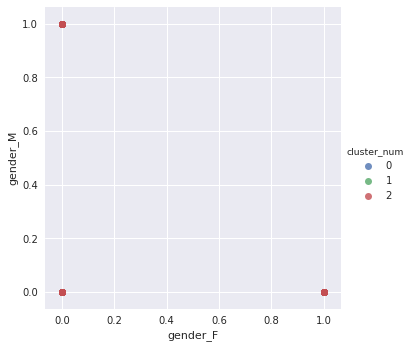

In [165]:
plt.figure(figsize = (20,10))
sns.lmplot(x='gender_F', y='gender_M', hue='cluster_num'
           , data=cluster_df, fit_reg=False);